# CSIT 456: Advanceed Techniques in Data Science

## Project:  Income Estimator
## Name:     Tom Prokop

### 1.1 Basic Information:

The purpose of this project is to design a model which can take demographic data from the United States census and see if this data is indicative of income. 

### 1.2 Project Objectives:

1. Is there any correlation between demographic data and income?
2. Can demographic data be used to predict someone's income bracket?

### 1.3 Description of Dataset:

The dataset used here is taken from the UCI Machine Learning repository.  It contains both categorical and integer data with 14 predictor variables and one target variable.  The predictor variables are different demographic data such as age, sex, marital status, occupation, etc.  The target variable is a binary variable called "class" which represents whether or not the individual greater than 50 thousand dollars or less than or equal to 50 thousand dollars.

## 2.  Exploration of Data Analysis
    

### 2.1 Data Preparation:


What we are trying to do here is see if these fourteen feature variables are indicative of whether or not an individual resides in the <=50K or the >50K income bracket.

In order to do so, there is some preprocessing that must be done first.  The steps are as follows:

1. Import all packages

In [178]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import warnings

from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.ensemble import RandomForestClassifier
import seaborn as sns


2. Read the CSV file into Pandas


In [3]:
adult = pd.read_csv("adult.csv")

3. Identify the feature and target variables


In [111]:
feature_names = list(adult.columns[0:14])
target_names = list(adult.columns[14:15])

print("Feature names: ", feature_names)
print("Target names: ", target_names)


Feature names:  ['age', 'fnlwgt', 'education-num', 'capitalgain', 'capitalloss', 'hoursperweek', 'x0_Federal-gov', 'x0_Local-gov', 'x0_Private', 'x0_Self-emp-inc', 'x0_Self-emp-not-inc', 'x0_State-gov', 'x0_Without-pay', 'x1_10th']
Target names:  ['x1_11th']


4. Convert the target variable into a boolean integer


In [5]:
adult['class'] = np.where(adult['class'] == '<=50K', 0, 1)

5. Drop NA values from features that contain them.


In [6]:
adult = adult.dropna(subset=['workclass', 'occupation', 'native-country'])

6. Convert categorical variables
    a. Use encode the categorical variables with OneHotEncoder, 
    b. Append the encoded variables to the dataset
    c. remove the original categorical variables fom the dataset

In [7]:
ohe = OneHotEncoder(handle_unknown='ignore')
enc_adult = pd.DataFrame(ohe.fit_transform(adult[['workclass', 'education', 'marital-status','occupation',
                                                  'relationship', 'race','sex','native-country']]).toarray())
enc_adult.columns = ohe.get_feature_names()
adult = adult.join(enc_adult)

cat_features = ['workclass', 'education', 'marital-status','occupation', 'relationship', 'race','sex','native-country']
for i in cat_features:
    adult = adult.drop([str(i)], axis=1)

7. Move the target class to the last column position

In [8]:
adult_na = adult[[c for c in adult if c not in ['class']]
       + ['class']]
adult = adult_na.dropna()

8. Establish the X and y for the train_test_split.  All columns except the last are the features, and the last column is the target, so we slice it this way.  Then we convert it into a numpy array for input into train_test_split.

In [9]:
X = adult.iloc[0:,0:-1].to_numpy()
y = adult.iloc[0:,-1].to_numpy()

9. Split the set into training and testing.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)


### 2.2 Models Selection:

In this analysis, we use a few different models:

1. KNN
2. Logistic Regression
3. DecisionTree
4. RandomForest

This is a binary classification task.

### 2.3.1 KNN:



In [200]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [201]:
leaf_size = list(range(1,30,5))
n_neighbors = list(range(1,30,5))
p = [1,2]
knn_params = dict(leaf_size=leaf_size, n_neighbors = n_neighbors, p = p)
knn_grid = GridSearchCV(knn, knn_params, cv=10, scoring = "roc_auc")
best_knn = knn_grid.fit(X_train, y_train)


In [202]:
print("Best params: ", best_knn.best_params_, "\nBest Score: ", best_knn.best_score_)

Best params:  {'leaf_size': 26, 'n_neighbors': 6, 'p': 1} 
Best Score:  0.5713761410945177


In [203]:
leaf_size = list(range(1,3))
n_neighbors = list(range(20,29))
p = [1,2]
knn_params = dict(leaf_size=leaf_size, n_neighbors = n_neighbors, p = p)
knn_grid = GridSearchCV(knn, knn_params, cv=10, scoring = 'roc_auc')
grid_knn = knn_grid.fit(X_train, y_train)

In [204]:
print("Best params: ", grid_knn.best_params_, "\nBest Score: ", grid_knn.best_score_)

Best params:  {'leaf_size': 1, 'n_neighbors': 20, 'p': 1} 
Best Score:  0.5514014861343798


In [106]:
best_knn = KNeighborsClassifier(leaf_size=1, n_neighbors=20, p=1)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=1,
                     weights='uniform')

### Logistic Regression

Our second model utilizes logistic regression.  For this model, we fit the training data then tune some select hyperparameters.  We will be tuning the "penalty", "C", and "solver" hyperparameters.

In [135]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [142]:
log_param_grid =  {'penalty' : ['l1', 'l2'],
                    'C' : np.logspace(-4, 4, 20),
                    'solver' : ['lbfgs', 'liblinear'] }

log_grid = GridSearchCV(lr, param_grid = log_param_grid, cv = 10, n_jobs=-1, scoring = 'roc_auc')
log_grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
      

In [144]:
print("Best params: ", log_grid.best_params_, "\nBest Score: ", log_grid.best_score_)

Best params:  {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'} 
Best Score:  0.8265049484055569


In [146]:
best_log = LogisticRegression(
                    C=log_grid.best_params_['C'], 
                    penalty=log_grid.best_params_['penalty'], 
                    solver=log_grid.best_params_['solver'])
best_log.fit(X_train, y_train)

LogisticRegression(C=0.08858667904100823, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Decision Tree

The third model is the decision tree.  For this model, the hyperparameters that we will examine are the max_depth and max_leaf_nodes. 

In [205]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
f_names = list(adult_na.columns[0:-1])
tree_viz = export_graphviz(tree, out_file=None, feature_names=f_names)
print(tree_viz)

# Output is deleted because this tree is enormous

In [207]:
param_grid_tree = {'max_depth':range(1,10), 'max_leaf_nodes':range(2,50)}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=0),
                        param_grid=param_grid_tree, cv=10, scoring = 'roc_auc')
grid_tree.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(1, 10),
                         'max_leaf_nodes': range(2, 50)},
             pre

In [208]:
print("Best Params: ", grid_tree.best_params_, "\nBest Score: ",grid_tree.best_score_)

Best Params:  {'max_depth': 9, 'max_leaf_nodes': 33} 
Best Score:  0.8323890332358352


In [209]:
param_grid_tree = {'max_depth':range(8,15), 'max_leaf_nodes':range(26,35)}
grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=0),
                        param_grid=param_grid_tree, cv=10, scoring = 'roc_auc')
grid_tree.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(8, 15),
                         'max_leaf_nodes': range(26, 35)},
             pr

In [210]:
print("Best Params: ", grid_tree.best_params_['max_depth'], "\nBest Score: ",grid_tree.best_score_)

Best Params:  9 
Best Score:  0.8323890332358352


In [211]:
best_tree = DecisionTreeClassifier(max_depth=grid_tree.best_params_['max_depth'], max_leaf_nodes=grid_tree.best_params_['max_leaf_nodes'])
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=33,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Random Forest

Our final model will be a Random Forest.  This is a collection of individual decision trees that can essentially pool their results to a consensus.  Like the other models, we begin by initializing a base model and fitting it to the training data.

In [128]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

We then once again use hyperparameters to prune the tree.  For this forest, however, we are going to go big and use several hyperparameters.  We will use RandomizedSearchCV to pick random parameters.  We will then use the "best" parameters from this randomized search to narrow the scope of our GridSearchCV since a full-out grid search on all these parameters would be far too computationally intensive.

In [129]:
random_forest_params = {'n_estimators':[100, 500, 1000, 1500, 2000], 
                         'bootstrap':[True, False],
                         'max_depth': [10, 30, 60, 90],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                       }

forest_random = RandomizedSearchCV(estimator = forest, param_distributions = random_forest_params, 
                                  n_iter = 2, cv=2, random_state=42, n_jobs=-1, scoring = 'roc_auc')

forest_random.fit(X_train, y_train)

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [131]:
print("Best params: ", forest_random.best_params_, "\nBest Score: ", forest_random.best_score_)

Best params:  {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True} 
Best Score:  0.8278963090986957


In [132]:
param_grid_forest = {'n_estimators':[800, 900, 1000, 1100, 1200], 
                         'bootstrap':[True],
                         'max_depth': list(range(25,35)),
                         'max_features': ['auto'],
                         'min_samples_leaf': [1],
                         'min_samples_split': list(range(9,11)),
                       }
                    
grid_forest = GridSearchCV(RandomForestClassifier(random_state=0),
                        param_grid=param_grid_forest, cv=2, n_jobs=-1, scoring = 'roc_auc')

grid_forest.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [133]:
print("Best Params: ", grid_forest.best_params_, "\nBest Score: ",grid_forest.best_score_)

Best Params:  {'bootstrap': True, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 1100} 
Best Score:  0.829748897770015


In [149]:
best_forest = RandomForestClassifier(bootstrap=grid_forest.best_params_['bootstrap'], 
                                    max_depth=grid_forest.best_params_['max_depth'],
                                    max_features=grid_forest.best_params_['max_features'],
                                    min_samples_leaf=grid_forest.best_params_['min_samples_leaf'],
                                    min_samples_split=grid_forest.best_params_['min_samples_split'],
                                    n_estimators=grid_forest.best_params_['n_estimators']
                                    )
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 3.  Evaluation

In summation, we have 4 models to evaluate:

1.  KNN
2.  Logistic Regression
3.  DecisionTree
4.  Random Forest

There are a few ways we can evaluate these models.  First, we can compare the ROC AUC scores.  By plotting the ROC curve for each of the models, we'll be able to see which has the highest area under the curve (AUC score) as well as the thresholds, which will be indicative of the best model.  

Additionally, we will look at the confusion matrices and classification reports for the models to see how each one performed individually.

In [195]:
def proba(model):
    m_proba = model.predict_proba(X_test)[:,1]
    return m_proba

def get_roc_auc(model):
    return roc_auc_score(y_test, proba(model))
                
def compare_roc_auc(model_1, model_2, model_3, model_4, name1, name2, name3, name4):
    m1_auc = get_roc_auc(model_1)
    m2_auc = get_roc_auc(model_2)
    m3_auc = get_roc_auc(model_3)
    m4_auc = get_roc_auc(model_4)

    scores = {name1:m1_auc, name2:m2_auc, name3:m3_auc, name4:m4_auc}
    maximum = max(scores, key=scores.get)
    
    print("Model Name: " +str(maximum),
          "\nBest ROC_AUC Score: ", scores[maximum])
            
    m_1_proba = proba(model_1)
    m_2_proba = proba(model_2)
    m_3_proba = proba(model_3)
    m_4_proba = proba(model_4)


    fpr1, tpr1, thresholds1 = roc_curve(y_test, m_1_proba)
    fpr2, tpr2, thresholds2 = roc_curve(y_test, m_2_proba)
    fpr3, tpr3, thresholds3 = roc_curve(y_test, m_3_proba)
    fpr4, tpr4, thresholds4 = roc_curve(y_test, m_4_proba)


    plt.plot([0, 1], [0, 1], 'k--') 
    plt.plot(fpr1, tpr1, label=str(name1), c='k')
    plt.plot(fpr2, tpr2, label=str(name2), c='orange')
    plt.plot(fpr3, tpr3, label=str(name3), c='b')
    plt.plot(fpr4, tpr4, label=str(name4), c='r')

    
    close_default = np.argmin(np.abs(thresholds1-0.5))
    plt.plot(fpr1[close_default], tpr1[close_default], '^', markersize=8,
             label="threshold 0.5 "+name1, fillstyle="none", c='k')
    
    close_default = np.argmin(np.abs(thresholds2-0.5))
    plt.plot(fpr2[close_default], tpr2[close_default], '^', markersize=8,
             label="threshold 0.5 "+name2, fillstyle="none", c='orange')
    
    close_default = np.argmin(np.abs(thresholds3-0.5))
    plt.plot(fpr3[close_default], tpr3[close_default], '^', markersize=8,
             label="threshold 0.5 "+name3, fillstyle="none", c='b')
    
    close_default = np.argmin(np.abs(thresholds4-0.5))
    plt.plot(fpr4[close_default], tpr4[close_default], '^', markersize=8,
             label="threshold 0.5 "+name4, fillstyle="none", c='r') 
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name1+ " "+name2+" "+name3+" "+name4+" ROC Curve")
    
    plt.legend(loc=4, prop={'size': 8})


def plot_report(model, name):
    
    c1 = confusion_matrix(y_test, model.predict(X_test))
    print(classification_report(y_test, model.predict(X_test)))
    print("Confusion Matrix: \n" ,c1)
    print()
    ax = plt.axes()
    sns.heatmap(c1/np.sum(c1), annot=True, ax = ax)
    ax.set_title(name+" Confusion Matrix Percentage")
    plt.show()
    
    

Model Name: Best Forest 
Best ROC_AUC Score:  0.8408477113171009


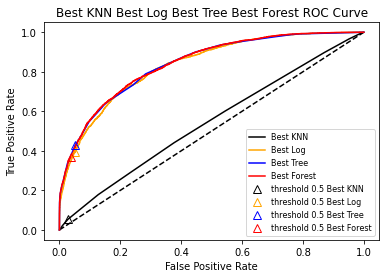

In [175]:
compare_roc_auc(best_knn, best_log, best_tree, best_forest, "Best KNN", "Best Log", "Best Tree", "Best Forest")


In [216]:
# AUC scores
print("KNN: ",get_roc_auc(best_knn), "\nLogReg: ",get_roc_auc(best_log), 
      "\nDecision Tree: ",get_roc_auc(best_tree), "\nRandom Forest: ", get_roc_auc(best_forest))

KNN:  0.5789353572708561 
LogReg:  0.8334390379789216 
Decision Tree:  0.8392621588490162 
Random Forest:  0.8408477113171009


              precision    recall  f1-score   support

           0       0.83      0.95      0.89      9513
           1       0.71      0.39      0.51      3053

    accuracy                           0.81     12566
   macro avg       0.77      0.67      0.70     12566
weighted avg       0.80      0.81      0.79     12566

Confusion Matrix: 
 [[9023  490]
 [1851 1202]]



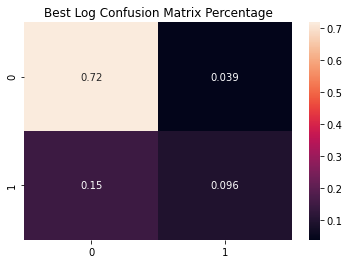

In [196]:
plot_report(best_log, "Best Log")

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      9513
           1       0.41      0.02      0.04      3053

    accuracy                           0.75     12566
   macro avg       0.59      0.51      0.45     12566
weighted avg       0.67      0.75      0.66     12566

Confusion Matrix: 
 [[9417   96]
 [2986   67]]



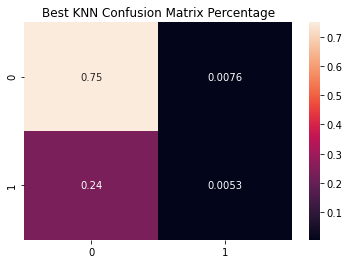

In [197]:
plot_report(best_knn, "Best KNN")

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      9513
           1       0.73      0.43      0.54      3053

    accuracy                           0.82     12566
   macro avg       0.78      0.69      0.71     12566
weighted avg       0.81      0.82      0.80     12566

Confusion Matrix: 
 [[9020  493]
 [1742 1311]]



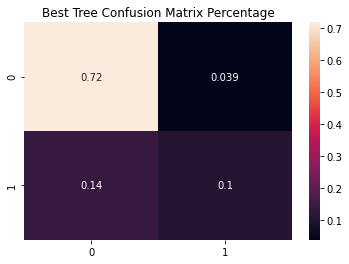

In [198]:
plot_report(best_tree, "Best Tree")

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      9513
           1       0.76      0.37      0.50      3053

    accuracy                           0.82     12566
   macro avg       0.79      0.67      0.69     12566
weighted avg       0.81      0.82      0.79     12566

Confusion Matrix: 
 [[9158  355]
 [1926 1127]]



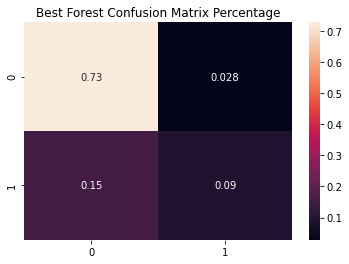

In [217]:
plot_report(best_forest, "Best Forest")